**By Peter A. Stokes, École Pratique des Hautes Études – Université PSL**


_These are brief notes and exercises on working with images using Python. They are intended as complements to classroom teaching. They assume a a basic level of Python programming, and that the relevant SciKit libraries have already been installed in your Python system. This notebook also assumes that you have already completed 1. Basic Image Manipulation with SciKit-Image, and that you have a pre-existing directory structure with images of Cambridge, Corpus Christi College MS 44 which can be obtained from Parker on the Web: https://parker.stanford.edu._

In a very interesting blog post, Jesse Hurlbut proposed different ways of calculating a 'manuscript average', by taking all the images of a complete manuscript and overlaying them on top of each other in different ways. Doing this shows very vividly the consistency (or lack thereof) in layout, and also highlights any specific pages which vary significantly from the norm. You can see the original blog post at http://jessehurlbut.net/wp/mssart/?page_id=2097

The goal of this exercise is to write a program using skimage to create our own 'manuscript average' images using our own manuscripts. We have already learned everything we need to do this in the first exercise; we just need to put it all together. This can also be done with the Python Image Library (PIL), and in some ways PIL is easier to use, but we are already familiar with skimage, and using it gives us a clearer idea of what's going on and allows us to go a bit further in our understanding of Python.

# Step By Step...

Let's go through the process step by step to begin with, and then we can put it all together at the end. This is always a good approach: to do things one bit at a time, testing along the way to make sure it all works, rather than trying to write everything at once and then having a real mess to sort out when things go wrong.

## Setup and initialisation

Very often, scripts consist of three parts: 

1. An initial part for importing libraries and setting up initial variables;
1. A main central part for doing the 'heavy' processing;
1. A final part for producing output (saving results, printing to the console, etc.)

We can see this pattern in the code here. First, we import the necessary libraries, initialise some variables, and read in the list of files that we will be processing.

In [ ]:
from skimage import io
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
from numpy import zeros, full, minimum
from matplotlib import pyplot as plt
import os, glob

directory = 'CCCC 44/'
filelist = glob.glob(directory + '*.jpg')

In order for the code to work properly, all the images need to be the same size. In practice the images are often slightly different sizes, so we will need to scale them. The problem is that we have to decide in advance what size all the images should be. Here, I've decided simply to find the smallest image and to scale all the other images to that. The procedure we follow is this:

1. Set the initial minimum size to zero
1. For each image file in the directory:
   1. If the minimum size is still zero then set the minimum to the size of this image.
   1. Otherwise, if the current image is smaller than the minimum size then save the current size as the minimum
   1. Otherwise, if this image is bigger than the smallest so far, then ignore this image and go on to the next one.
   
The last two 'otherwise' can be rewritten as follows:

1. Set the initial minimum size to zero
1. For each image file in the directory:
   1. If the minimum size is still zero then set the minimum to the size of this image.
   1. Otherwise, set the current minimum to either the value it has now or to the size of the new image, whichever is smaller.
   
This is harder for us to understand but is a bit easier for the computer.

In [ ]:
minx = 0
miny = 0

for f in filelist:
    im = io.imread(f)
        
    if (minx, miny) == (0,0):
        minx, miny, _ = im.shape
    else:
        x, y, _ = im.shape
        minx = min(x, minx)
        miny = min(y, miny)

Now we need to set up the images. We create two 'empty' images to which we will add all the images from our manuscript. The one for blending images should be entirely black to begin with, and the one for the 'darker' operation should be white. In order to do this, we need to remember that in sklearn, images are just cases of [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), so we can use [`zeros`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html) and [`full`](https://numpy.org/doc/stable/reference/generated/numpy.full.html?highlight=full#numpy.full) to achieve this.

We also need to decide what transparency value to use for the images. Ideally it makes sense to use an equal transparency for each image, with the total transparency at 100%. This means that if there are two images then each image should be 50% transparent; four images should be 25% and so on, so n images should have transparency of 1/n. There's a small problem here in that if the transparency is too small then the images seem to come out as black, so we have to set a minimum transparencey as well. A value of `0.01` seems to work, but feel free to try different values here.

In [ ]:
alpha = max(1.0/len(filelist), 0.01)

# Create new black image (i.e. an ndarray of integers filled with zeros)
im_blend = zeros((minx, miny, 3), dtype=int)

# Create new white image (i.e. an ndarray of integers filled with 255)
im_dark = full((minx, miny, 3), 255, dtype=int)

# Show one image, just to check that it looks OK
io.imshow(im_dark)

## Processing the images

Now that we have set everything up, we can start processing the images. To begin with, let's figure out the process for a single image, and then we can put it all together into a loop.

### Loading the images

The first thing to do is to load in the image and resize it, which we can do very easily with scikit's [`io.imread`](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread) and [`transform.resize`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize):

In [ ]:
f = directory + '001.jpg'
im = io.imread(f)

im_rz = resize(im, (minx, miny))

### Flipping (or mirroring) the images

We then need to see if the image is of a recto or a verso page. Normally, rectos and versos are mirrors of each other in terms of page layout (i.e. the left margin on a recto will match the right margin on a verso, and so on). For this reason we need to mirror all the recto pages (or all the versos) to make sure they lign up. In order to do this, we assume that the file name includes the necessary information:

1. If the file name (excluding the extension) ends in 'v' then we assume it's a verso (e.g. 002v, 35v, etc.);
1. If the file name ends in 'r' then we assume it's a recto (e.g. 215r, etc.)
1. If the file name comprises a number, then we assume it refers to a page, and so:
   1. If the number is odd then we assume it's a recto
   1. If the number is even then we assume it's a verso

In order to tell if a number is even or odd, we can use the _modulo_ operator, %. The modulo operator gives the remainder if the first number is divided by the second number. Therefore n % 2 will be zero if n is even, and will be one if n is odd.

There is one last problem: how do we flip an image with scikit-image? Unlike PIL, there is no 'flip' or 'mirror' available. However, we don't need it, because we can use Python's array indexing, including a negative value for the step part of the slice. To reverse a list (or an array) we simply slice the whole list, but provide a negative step:

In [ ]:
example = [1,2,3,4,5,6,7,8,9,10]

# Use list slicing to print the whole list
print(example[:])

# Use list slicing and steps to print every second number
print(example[::2])

# Use list slicing and steps to print the list backwards
print(example[::-1])

We can now put these steps together to decide which images need to be mirrored, and to do the mirroring:

In [ ]:
# Get the basename without extension
fol = os.path.splitext(os.path.basename(f))[0]

# We need to flip all the versos (or all the rectos)
# so that the page layout matches.
if (fol.lower()[-1] == 'v'):
    imfinal = im_rz[:, ::-1, :]
elif (fol.lower()[-1] == 'r'):
    imfinal = im_rz
elif (int(fol) % 2 == 0):
    imfinal = im_rz[:, ::-1, :]
else:
    imfinal = im_rz
    
io.imshow(imfinal)

### Combining the images with 'blend'

We can now combine the images. Like Jesse Hurlbut, we want to use two different methods: blending, to blend the different images equally together, and darkening, to preserve the darkest part of each image. Let's look first at blending. PIL has `blend` built in, so we could use that, but in fact it's very easy to do with skimage if you think about it a bit. The idea here is that we take each image, one at a time, we make it partly transparent, and we add that transparent image to the sum of all the other images. We can do that with matrix manipulation: we can take (say) 10% of each pixel in our our new image and add it to 90% of the corresponding pixel in the current image. 
We won't see much at this point, of course, because we only have one image, but we can have a look anyway just to make sure that something happened.

In [ ]:
# Add 10% of the new image to 90% of the base image 
im_blend = 0.1 * imfinal + (1-0.1) * im_blend

io.imshow(im_blend)

Now we want to put all of this together into a single loop. Notice that this follows the same pattern as we used for automatic batch processing of a set of images in Exercice 1. Rather than using 10% for our blending, we should also use the value of alpha that we calculated above.

A loop like this might take a long time to run, so let's add some `print()` statements to tell the user that things are happening, and also because if there is a problem then this can help us understand where things went wrong.

In [ ]:
for f in filelist:
    print('Reading image', f)
    im = io.imread(f)

    im_rz = resize(im, (minx, miny))
    
    # Get the basename without extension
    fol = os.path.splitext(os.path.basename(f))[0]

    # We need to flip all the versos (or all the rectos)
    # so that the page layout matches.
    if (fol.lower()[-1] == 'v'):
        imfinal = im_rz[:, ::-1, :]
    elif (fol.lower()[-1] == 'r'):
        imfinal = im_rz
    elif (int(fol) % 2 == 0):
        imfinal = im_rz[:, ::-1, :]
    else:
        imfinal = im_rz
        
    im_blend = alpha * imfinal + (1-alpha) * im_blend

io.imshow(im_blend)

### Combining the images with 'darken'

The other method that we want to test is 'darken'. This means that we look at each pixel in the first image, compare it to the corresponding pixel in the second image, and take whichever is darker. Once again, we can do this easily with skimage by using the capacities of the numpy `ndarray`, if we remember that 'darker' here means 'lower value' (in other words closer to zero). So the darker of two pixels is the one with the minimum value, and we can therefore use Numpy's element-wise `minimum`. Let's repeat what we did for 'blend', replacing the blending with the minimum:

In [ ]:
im_dark = minimum(im_dark, imfinal)

io.imshow(im_dark)

In [ ]:
for f in filelist:
    print('Reading image', f)
    im = io.imread(f)

    im_rz = resize(im, (minx, miny))
    
    # Get the basename without extension
    fol = os.path.splitext(os.path.basename(f))[0]

    # We need to flip all the versos (or all the rectos)
    # so that the page layout matches.
    if (fol.lower()[-1] == 'v'):
        imfinal = im_rz[:, ::-1, :]
    elif (fol.lower()[-1] == 'r'):
        imfinal = im_rz
    elif (int(fol) % 2 == 0):
        imfinal = im_rz[:, ::-1, :]
    else:
        imfinal = im_rz
        
    im_dark = minimum(im_dark, imfinal)

io.imshow(im_dark)

## The Output

After this we now have our two 'manuscript average' images: one using the blending method and the other using the 'darker' method. All we need to do now is save the images.

It turns out also that the 'blend' image is often very faint. This could probably be fixed by playing with the alpha values above, but we can also use one of skimage's automatic contrast adjustments instead. 

In [ ]:
# The blended image is a bit faint, so let's enhance the contrast
im_blend = equalize_adapthist(im_blend)

io.imsave(directory + 'image_blend.png', im_blend)
io.imsave(directory + 'image_dark.png', im_blend)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(im_blend)
ax[0].set_title("Blended image")
ax[1].imshow(im_dark)
ax[1].set_title("Darkened image")

fig.tight_layout()
plt.show()

# Putting it All Together

That's it! Those are all the steps we need. If we want then we can now put it all together into a single piece of code which you can copy and paste into a stand-alone script to run yourself if you want. Have fun making manuscript averages with your own images, and do also try changing and improving the code according to your own interests and needs.

Reading image sizes...
Reading image CCCC 44/176.jpg
Reading image CCCC 44/406.jpg
Reading image CCCC 44/016.jpg
Reading image CCCC 44/201.jpg
Reading image CCCC 44/361.jpg
Reading image CCCC 44/161.jpg
Reading image CCCC 44/001.jpg
Reading image CCCC 44/216.jpg
Reading image CCCC 44/376.jpg
Reading image CCCC 44/366.jpg
Reading image CCCC 44/206.jpg
Reading image CCCC 44/011.jpg
Reading image CCCC 44/401.jpg
Reading image CCCC 44/171.jpg
Reading image CCCC 44/371.jpg
Reading image CCCC 44/211.jpg
Reading image CCCC 44/166.jpg
Reading image CCCC 44/101.jpg
Reading image CCCC 44/061.jpg
Reading image CCCC 44/276.jpg
Reading image CCCC 44/316.jpg
Reading image CCCC 44/116.jpg
Reading image CCCC 44/076.jpg
Reading image CCCC 44/261.jpg
Reading image CCCC 44/301.jpg
Reading image CCCC 44/311.jpg
Reading image CCCC 44/271.jpg
Reading image CCCC 44/066.jpg
Reading image CCCC 44/106.jpg
Reading image CCCC 44/306.jpg
Reading image CCCC 44/266.jpg
Reading image CCCC 44/071.jpg
Reading image CCC

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


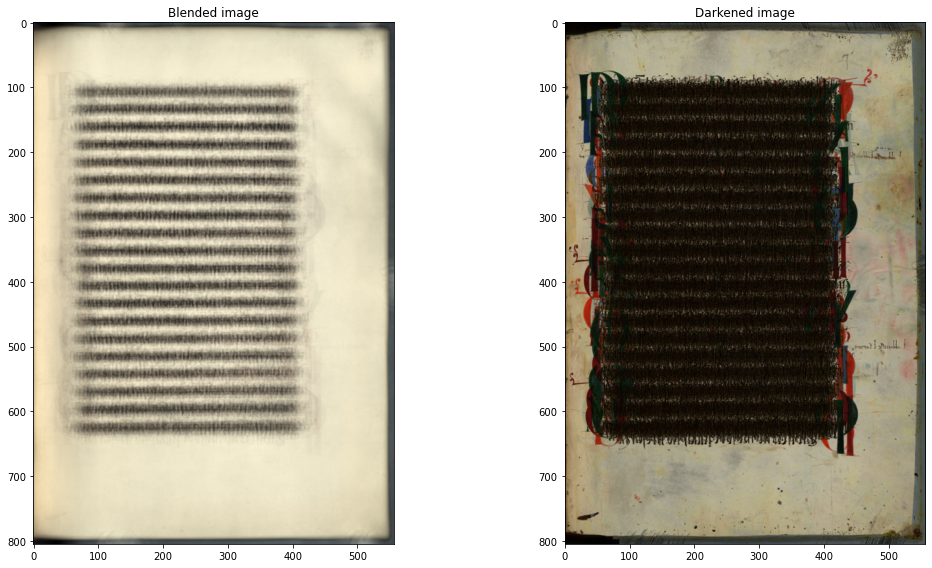

In [1]:
"""
Basic script to create 'manuscript average' pages, based on discussion by Jesse
Hurlbut at http://jessehurlbut.net/wp/mssart/?page_id=2097.

This version assumes a directory of JPG images specified in the directory
variable below.

Created on Wed May 16 14:05:04 2018
Updated on Tue Oct 26 10:12:36 2021 to use skimage instead of PIL

@author: Peter A. Stokes, École Pratique des Hautes Études – Université PSL
"""

from skimage import io
from skimage.transform import resize
from skimage.exposure import equalize_adapthist
from numpy import zeros, full, minimum
from matplotlib import pyplot as plt
import os, glob

directory = 'CCCC 44/'
filelist = glob.glob(directory + '*.jpg')

minx = 0
miny = 0

# First find the smallest image to resize to
print('Reading image sizes...')
for f in filelist:
    im = io.imread(f)
        
    if (minx, miny) == (0,0):
        minx, miny, _ = im.shape
    else:
        x, y, _ = im.shape
        minx = min(x, minx)
        miny = min(y, miny)
        
# Precalculate alpha to bring it out of the inner loop below
# The alpha seems to have a minimum value below which the images are black
alpha = max(1.0/len(filelist), 0.01)
    
# Create new black image for blending, and white image for darkening
im_blend = zeros((minx, miny, 3), dtype=int)
im_dark = full((minx, miny, 3), 255, dtype=int)

# Now process all the images in the directory
for f in filelist:
    print('Reading image', f)
    im = io.imread(f)

    im_rz = resize(im, (minx, miny))
    
    # Get the basename without extension
    fol = os.path.splitext(os.path.basename(f))[0]

    # We need to flip all the versos (or all the rectos)
    # so that the page layout matches.
    if (fol.lower()[-1] == 'v'):
        imfinal = im_rz[:, ::-1, :]
    elif (fol.lower()[-1] == 'r'):
        imfinal = im_rz
    elif (int(fol) % 2 == 0):
        imfinal = im_rz[:, ::-1, :]
    else:
        imfinal = im_rz
        
    im_blend = alpha * imfinal + (1-alpha) * im_blend
    im_dark = minimum(im_dark, imfinal)

# The blended image tends to be very faint, so let's enhance the contrast
im_blend = equalize_adapthist(im_blend)

# Save the results as new images
io.imsave(directory + 'image_blend.png', im_blend)
io.imsave(directory + 'image_dark.png', im_blend)

# And display the results to the user
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(im_blend)
ax[0].set_title("Blended image")
ax[1].imshow(im_dark)
ax[1].set_title("Darkened image")

fig.tight_layout()
plt.show()

And there you have it! Try the code on different manuscripts (and printed books), and see if you can improve or extend it. For instance, you will have noticed a warning about 'Lossy conversion from float64 to uint8': can you figure out how to fix the code so that this doesn't appear?

Enjoy!

---
![Licence Creative Commons](https://i.creativecommons.org/l/by/4.0/88x31.png)
This work (the contents of this Jupyter Python notebook) is licenced under a [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)